In [1]:
# ipynb形式のライブラリのインポート
%run ./lib.ipynb

In [2]:
# DF = returnRawDFperBenchmark(Benchmark = "is", fix="Classes", benchmarkClass = ["A", "B", "C", "D"], FixedProcess = 64, Processes = [1,2,4,8,16,32,64,128,256], FixedBenchmarkClass="B")
# DF

In [3]:
# raw_x = DF.columns.tolist()
# functionName = "MPI_Irecv()"
# raw_y = [DF.at[functionName, x] for x in raw_x]

# # グラフのプロット
# fig = plt.figure(figsize=(12, 9))
# ## 実データをsklearn用に変形
# raw_x = np.array(raw_x).reshape(-1,1)
# raw_y = np.array(raw_y).reshape(-1, 1)
# ## 説明変数と目的変数に分割
# notTrain_x, train_x, target_x = raw_x[0], raw_x[1:-1], raw_x[-1]
# notTrain_y, train_y, target_y = raw_y[0], raw_y[1:-1], raw_y[-1]
# ## 実データをそれぞれプロット
# plt.scatter(train_x, train_y, marker="o", label="予測に用いた関数コール回数")
# plt.scatter(target_x, target_y, marker="o", label="予測したい関数コール回数の実測値")
# plt.scatter(notTrain_x, notTrain_y, marker="o", label="最初のデータを除外した時に予測に用いなかった関数コール回数")
# ## モデル式をプロットするために変数”plot_x”を用意する
# plot_x_min = 1.0
# plot_x_max = 256.0
# ### モデル式としてプロットする最低値の設定
# plot_x = np.linspace(plot_x_min, plot_x_max, 500)
# plot_x = np.array(plot_x).reshape(-1, 1)
# ## モデルを [1 - 1/n] として計算
# plot_y = 1 - 1/plot_x
# plt.plot(plot_x, plot_y)


# modelIpMk2 = ModelIp_mk2(train_x=train_x, train_y=train_y, target_x=target_x, target_y=target_y)
# modelIpMk2.calc_lr()
# plot_y = modelIpMk2.predict(plot_x)
# plt.plot(plot_x, plot_y)


In [4]:
# raw_x

# raw_y

In [5]:
benchmarkName = "cg"
fixed = "Process"
benchmarkClasses = ["A", "B", "C", "D"]
FixedProcess = 64
Processes = [1,2,4,8,16,32,64,128,256]
FixedBenchmarkClass = "B"

In [6]:
DF = collectFunctionNamesPerBenchmark(benchmarkName = "cg", benchmarkClasses = benchmarkClasses, processes = Processes)
# for benchmarkClass in benchmarkClasses:
#     for Process in Processes:
#         pass

In [7]:
DF

,functionName,call,benchmarkClass,benchmarkName,process
0,.TAU_application,1.0,1,cg,1
1,CG,1.0,1,cg,1
2,MPI_Finalize(),1.0,1,cg,1
3,INITIALIZE_MPI,1.0,1,cg,1
4,MPI_Init(),1.0,1,cg,1
...,...,...,...,...,...
17,MPI_Reduce(),1.0,256,cg,256
18,SETUP_SUBMATRIX_INFO,1.0,256,cg,256
19,MPI_Comm_size(),1.0,256,cg,256
20,MPI_Comm_rank(),1.0,256,cg,256


In [8]:
functionNames = DF["functionName"]
functionNames = tuple(functionNames)
functionNames

('.TAU_application',
 'CG',
 'MPI_Finalize()',
 'INITIALIZE_MPI',
 'MPI_Init()',
 'CONJ_GRAD',
 'MAKEA',
 'MPI_Wait()',
 'SPRNVC',
 'ICNVRT',
 'SPARSE',
 'MPI_Send()',
 'VECSET',
 'MPI_Irecv()',
 'MPI_Bcast()',
 'ALLOC_SPACE',
 'MPI_Barrier()',
 'MPI_Reduce()',
 'MPI_Comm_rank()',
 'SETUP_SUBMATRIX_INFO',
 'MPI_Comm_size()',
 'SETUP_PROC_INFO',
 '.TAU_application',
 'CG',
 'MPI_Finalize()',
 'INITIALIZE_MPI',
 'MPI_Init()',
 'CONJ_GRAD',
 'MAKEA',
 'MPI_Wait()',
 'SPRNVC',
 'ICNVRT',
 'SPARSE',
 'MPI_Send()',
 'VECSET',
 'MPI_Irecv()',
 'MPI_Bcast()',
 'ALLOC_SPACE',
 'MPI_Barrier()',
 'MPI_Reduce()',
 'SETUP_SUBMATRIX_INFO',
 'MPI_Comm_rank()',
 'MPI_Comm_size()',
 'SETUP_PROC_INFO',
 '.TAU_application',
 'CG',
 'MPI_Finalize()',
 'INITIALIZE_MPI',
 'MPI_Init()',
 'CONJ_GRAD',
 'MAKEA',
 'SPRNVC',
 'MPI_Wait()',
 'ICNVRT',
 'MPI_Send()',
 'SPARSE',
 'VECSET',
 'ALLOC_SPACE',
 'MPI_Irecv()',
 'MPI_Bcast()',
 'MPI_Barrier()',
 'MPI_Reduce()',
 'MPI_Comm_rank()',
 'MPI_Comm_size()',
 'SE

In [9]:
print(DF.query('functionName.str.endswith("VECSET")', engine='python'))

   functionName       call  benchmarkClass benchmarkName process
12       VECSET     7875.0               1            cg       1
12       VECSET     8750.0               1            cg       2
12       VECSET    10500.0               1            cg       4
12       VECSET    14000.0               1            cg       8
12       VECSET    14000.0               1            cg      16
11       VECSET    14000.0               1            cg      32
11       VECSET    14000.0               1            cg      64
11       VECSET    14000.0               1            cg     128
11       VECSET    14000.0               1            cg     256
12       VECSET    21625.0               4            cg       1
12       VECSET    29250.0               4            cg       2
12       VECSET    44500.0               4            cg       4
13       VECSET    75000.0               4            cg       8
13       VECSET    75000.0               4            cg      16
13       VECSET    75000.

# 反比例モデルの修正

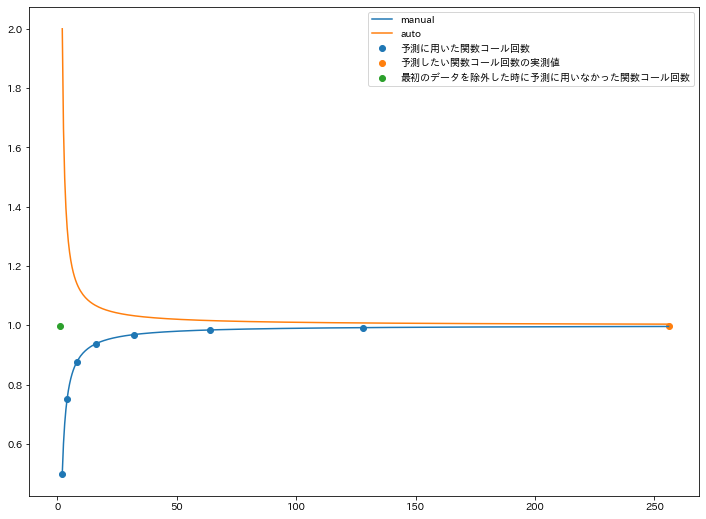

In [16]:
DF = returnRawDFperBenchmark(Benchmark = "is", fix="Classes", benchmarkClass = ["A", "B", "C", "D"], FixedProcess = 64, Processes = [1,2,4,8,16,32,64,128,256], FixedBenchmarkClass="B")

raw_x = DF.columns.tolist()
functionName = "MPI_Irecv()"
raw_y = [DF.at[functionName, x] for x in raw_x]

# グラフのプロット
fig = plt.figure(figsize=(12, 9))
## 実データをsklearn用に変形
raw_x = np.array(raw_x).reshape(-1,1)
raw_y = np.array(raw_y).reshape(-1, 1)
## 説明変数と目的変数に分割
notTrain_x, train_x, target_x = raw_x[0], raw_x[1:-1], raw_x[-1]
notTrain_y, train_y, target_y = raw_y[0], raw_y[1:-1], raw_y[-1]
## 実データをそれぞれプロット
plt.scatter(train_x, train_y, marker="o", label="予測に用いた関数コール回数")
plt.scatter(target_x, target_y, marker="o", label="予測したい関数コール回数の実測値")
plt.scatter(notTrain_x, notTrain_y, marker="o", label="最初のデータを除外した時に予測に用いなかった関数コール回数")
## モデル式をプロットするために変数”plot_x”を用意する
plot_x_min = 2.0
plot_x_max = 256.0
### モデル式としてプロットする最低値の設定
plot_x = np.linspace(plot_x_min, plot_x_max, 500)
plot_x = np.array(plot_x).reshape(-1, 1)
## モデルを [1 - 1/n] として計算
plot_y = 1 - 1/plot_x
plt.plot(plot_x, plot_y, label="manual")

modelIP_mk2 = ModelIp_mk2(train_x=train_x, train_y=train_y, target_x=target_x, target_y=target_y)
modelIP_mk2.calc_lr()
plot_y_IP_mk2 = modelIP_mk2.predict(plot_x)
plt.plot(plot_x, plot_y_IP_mk2, label="auto")



plt.legend()